In [5]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from utils import load_results
from utils import precision_recall_scores as roc
from utils import mpl_stylesheet
from utils import utils
mpl_stylesheet.banskt_presentation(fontfamily = 'system')

def get_dict_for_method(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'tejaas_maf':
            sb = '0.001'
            filepath = os.path.join(datadir, 'tejaas', 'mafnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_maf':
            sb = '0.001'
            filepath = os.path.join(datadir, 'tejaas_rand', 'mafnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_perm':
            filepath = os.path.join(datadir, 'tejaas', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_perm':
            filepath = os.path.join(datadir, 'tejaas_rand', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'cpma':
            filepath = os.path.join(datadir, 'tejaas', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'cpma_rand':
            filepath = os.path.join(datadir, 'tejaas_rand', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)
        elif method == 'matrixeqtl_rand':
            filepath = os.path.join(datadir, 'matrixeqtl_rand', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

def get_dict_for_no_crxn(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'gtex_MatrixEQTL_chr{:d}.transout'.format(chrm))
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'gtex_MatrixEQTL_chr{:d}.transout'.format(chrm))
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)

    res = dict()
    for d in chrmdicts:
        for k, v in d.items():
            res[k] = v
    return res

INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()


def validate(testdict, valdict, smax = 1.301, nmax = None, empirical = False):
    if empirical:
        if nmax is None:
            totsnps = len(list(testdict.keys()))
            nmax = int(np.round(totsnps/20))
        sorted_snps = [x[0] for x in sorted(valdict.items(), key=lambda x: x[1], reverse = True)]
        topsnps = sorted_snps[:nmax]
    else:
        topsnps = [k for k,v in valdict.items() if v > smax]
    data = dict()
    for key, value in testdict.items():
        data[key] = ValidateResult(rsid = key, stat = value, causality = 0)
    for key in topsnps:
        if key in data:
            data[key] = ValidateResult(rsid = key, stat = data[key].stat, causality = 1)
    datalist = list()
    for key, value in data.items():
        datalist.append(value)
    return datalist

In [18]:
chrms = [7, 8]
datasets = ['gtex-hlv', 'gtex-ms']
methods = ['tejaas_maf', 'tejaas_perm', 'cpma', 'matrixeqtl', 'matrixeqtl_fdr',
           'tejaas_rand_maf', 'tejaas_rand_perm', 'cpma_rand', 'matrixeqtl_rand']
#methods = ['tejaas_maf', 'tejaas_rand_maf']
input_dir = '/scratch/sbanerj/trans-eqtl/dev-pipeline/lmcorrected'
#input_dir = '/scratch/sbanerj/trans-eqtl/dev-pipeline/uncorrected'

In [19]:
res = collections.defaultdict(dict)
for key in methods:
    if input_dir.endswith('uncorrected'):
        res[key]['test']     = get_dict_for_no_crxn(key, input_dir, chrms, datasets[0])
        res[key]['crossval'] = get_dict_for_no_crxn(key, input_dir, chrms, datasets[1])
    else:
        res[key]['test']     = get_dict_for_method(key, input_dir, chrms, datasets[0])
        res[key]['crossval'] = get_dict_for_method(key, input_dir, chrms, datasets[1])

Reading gtex-hlv for tejaas_maf
Reading gtex-ms for tejaas_maf
Reading gtex-hlv for tejaas_perm
Reading gtex-ms for tejaas_perm
Reading gtex-hlv for cpma
Reading gtex-ms for cpma
Reading gtex-hlv for matrixeqtl
Reading gtex-ms for matrixeqtl
Reading gtex-hlv for matrixeqtl_fdr
Reading gtex-ms for matrixeqtl_fdr
Reading gtex-hlv for tejaas_rand_maf
Reading gtex-ms for tejaas_rand_maf
Reading gtex-hlv for tejaas_rand_perm
Reading gtex-ms for tejaas_rand_perm
Reading gtex-hlv for cpma_rand
Reading gtex-ms for cpma_rand
Reading gtex-hlv for matrixeqtl_rand
Reading gtex-ms for matrixeqtl_rand


In [ ]:
#import pickle
#pickle.dump(res, open( "my_res.pkl", "wb" ))
#res = pickle.load(open("my_res.pkl", "rb"))

In [20]:
valres = collections.defaultdict(dict)
for key in methods:
    print("Validating {:s}".format(key))
    testdict, valdict = utils.get_compatible_snp_dicts(res[key]['test'], res[key]['crossval'])
    valres[key] = validate(testdict, valdict, empirical=True)

Validating tejaas_maf
Validating tejaas_perm
Validating cpma
Validating matrixeqtl
Validating matrixeqtl_fdr
Validating tejaas_rand_maf
Validating tejaas_rand_perm
Validating cpma_rand
Validating matrixeqtl_rand


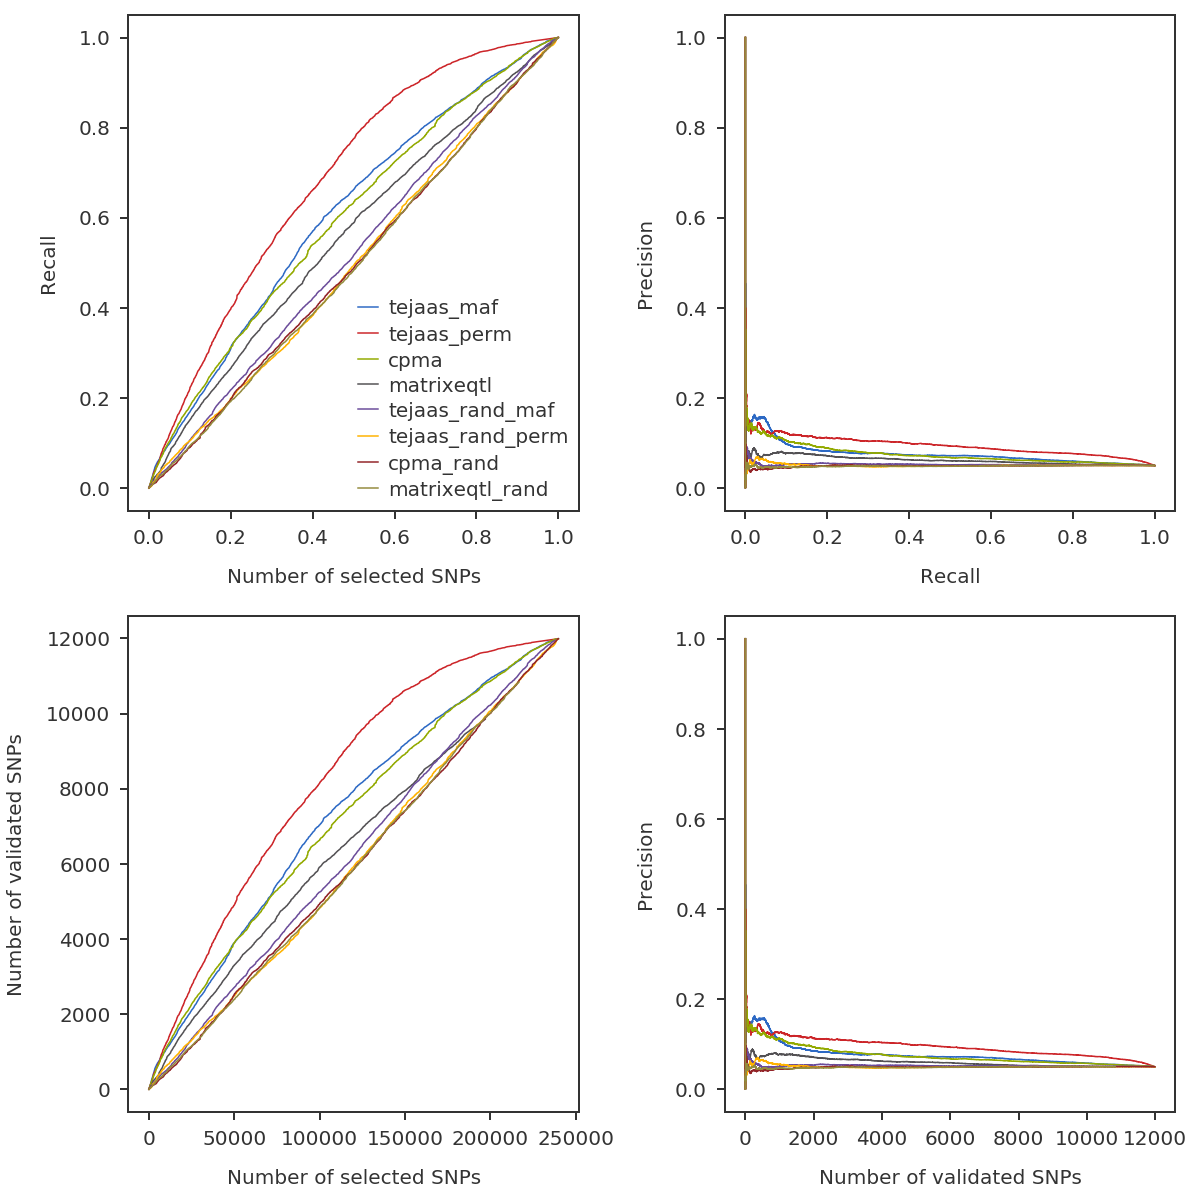

In [17]:
#outfile = 'gtex_ms_hlv_lmcorrected_validation_tejaas-sb0_01_chr-7-8.pdf'
#outfile = 'validation_methods_comparison_matrixeqtl_ms_hlv_no_correction.png'
outfile = "../plots/gtex_hlv_ms_lmcorrected_validation_chr7-8.png"

fig = plt.figure(figsize = (17, 17))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plot_methods = ['tejaas_perm', 'cpma', 'matrixeqtl',
                'tejaas_rand_perm', 'cpma_rand', 'matrixeqtl_rand']
plot_methods = ['matrixeqtl', 'matrixeqtl_fdr']
plot_methods = ['tejaas_maf', 'tejaas_perm', 'cpma', 'matrixeqtl',
                'tejaas_rand_maf', 'tejaas_rand_perm', 'cpma_rand', 'matrixeqtl_rand']

for key in plot_methods:
    nsel, tpr, ppv, valids = roc.confusion_matrix(valres[key])
    scaled_nsel = nsel / max(nsel)
    ax1.plot(scaled_nsel, tpr, label = key)
    ax2.plot(tpr, ppv, label = key)
    ax3.plot(nsel, valids, label = key)
    ax4.plot(valids, ppv, label = key)

    
mlabel = r'Number of selected SNPs'
ax1.set_xlabel(mlabel)
ax3.set_xlabel(mlabel)
mlabel = r'Recall'
ax1.set_ylabel(mlabel)
ax2.set_xlabel(mlabel)
mlabel = r'Number of validated SNPs'
ax4.set_xlabel(mlabel)
ax3.set_ylabel(mlabel)
mlabel = r'Precision'
ax2.set_ylabel(mlabel)
ax4.set_ylabel(mlabel)

#ax2.set_xlim([0, 1000])
#ax1.set_xlim([0, 10000])
#ax1.set_ylim([0, 5000])
ax1.legend()
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

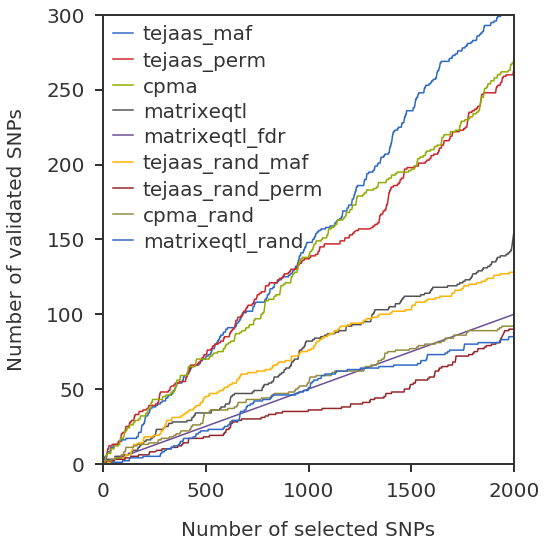

In [10]:
#outfile = 'gtex_ms_hlv_lmcorrected_validation_tejaas-sb0_01_chr-7-8.pdf'
#outfile = 'validation_methods_comparison_matrixeqtl_ms_hlv_no_correction.png'

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)


for key in plot_methods:
    nsel, tpr, ppv, valids = roc.confusion_matrix(valres[key])
    scaled_nsel = nsel / max(nsel)
    #ax1.plot(scaled_nsel, tpr, label = key)
    #ax2.plot(tpr, ppv, label = key)
    ax1.plot(nsel, valids, label = key)
    #ax4.plot(valids, ppv, label = key)

    
mlabel = r'Number of selected SNPs'
ax1.set_xlabel(mlabel)
mlabel = r'Number of validated SNPs'
ax1.set_ylabel(mlabel)

ax1.set_xlim([0, 2000])
ax1.set_ylim([0, 300])
ax1.legend()
plt.tight_layout()
#plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [16]:
res['matrixeqtl_fdr']['test']

{'rs34300626': -0.0,
 'rs111892338': -0.0,
 'rs1859803': -0.0,
 'rs306723': -0.0,
 'rs7781037': -0.0,
 'rs188277477': -0.0,
 'rs59635281': -0.0,
 'rs59338137': -0.0,
 'rs7777338': -0.0,
 'rs59191328': -0.0,
 'rs3923645': -0.0,
 'rs112291485': -0.0,
 'rs10258356': -0.0,
 'rs4352738': -0.0,
 'rs4723608': -0.0,
 'rs61399826': -0.0,
 'rs73183034': -0.0,
 'rs10793417': -0.0,
 'rs2706166': -0.0,
 'rs73183035': -0.0,
 'rs58404784': -0.0,
 'rs9692439': -0.0,
 'rs4729233': -0.0,
 'rs57600918': -0.0,
 'rs117813445': -0.0,
 'rs66472127': -0.0,
 'rs79813992': -0.0,
 'rs60609314': -0.0,
 'rs17208592': -0.0,
 'rs17274411': -0.0,
 'rs62446501': -0.0,
 'rs1132163': -0.0,
 'rs6964219': -0.0,
 'rs34028700': -0.0,
 'rs13231277': -0.0,
 'rs6946939': -0.0,
 'rs741064': -0.0,
 'rs11772167': -0.0,
 'rs10241715': -0.0,
 'rs4609124': -0.0,
 'rs717657': -0.0,
 'rs55938335': -0.0,
 'rs10253422': -0.0,
 'rs2032958': -0.0,
 'rs10271288': -0.0,
 'rs10228509': -0.0,
 'rs76020679': -0.0,
 'rs7777880': -0.0,
 'rs69448